In [1]:
# Imports

import cv2
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

import time

import test

cascade_classifier_path = '../env-tcc/lib/python3.6/site-packages/cv2/data/'
checkpoint_dir_path = './model_logs/release_celeba_256/'

/home/izabel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[2018-10-28 13:42:50 @__init__.py:79] Set root logger. Unset logger with neuralgym.unset_logger().
[2018-10-28 13:42:50 @__init__.py:80] Saving logging to file: neuralgym_logs/20181028134250097618.


In [2]:
# Imagem a ser carregada
IMG_NUMBER = '0'

# Define os caminhos das imagens (original, mascara e inpaint)

#TODO: encontrar métodos para, dada uma imagem JPG ou PNG, transformar uma em outra
source_jpg = 'img_' + IMG_NUMBER + '.jpg'
source_png = 'img_' + IMG_NUMBER + '.png'

# Imagem original
img_filepath = './images/' + source_jpg

# Máscara
mask_filepath = './masks/' + 'mask_'+ source_png

# Inpaint com OpenCV 
inpaint_opencv_filepath = './inpaints/' + 'inpaint_opencv_' + source_jpg

# Inpaint com Generative Contextual Attention
inpaint_generative_filepath = './inpaints/' + 'inpaint_generative_' + source_png

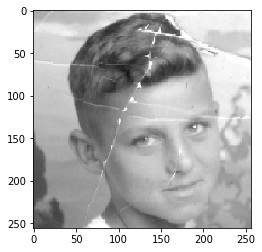

In [3]:
# Inicializa a imagem
image = np.asarray(Image.open(img_filepath))

plt.imshow(image)

<h1>Identificação do rosto e olhos</h1>

CPU times: user 142 ms, sys: 11.7 ms, total: 153 ms
Wall time: 83.8 ms


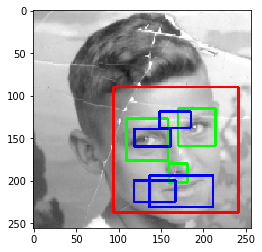

In [4]:
%%time

face_cascade = cv2.CascadeClassifier(cascade_classifier_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascade_classifier_path + 'haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier(cascade_classifier_path + 'haarcascade_smile.xml')


img = cv2.imread(img_filepath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
    eyes = eye_cascade.detectMultiScale(roi_gray) #green
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
    smile = smile_cascade.detectMultiScale(roi_gray) #blue
    for (ex,ey,ew,eh) in smile:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,0,255),2)

i = np.asarray(img)

plt.imshow(i)

<h1> Criação da máscada </h1>

CPU times: user 18 ms, sys: 0 ns, total: 18 ms
Wall time: 13.5 ms


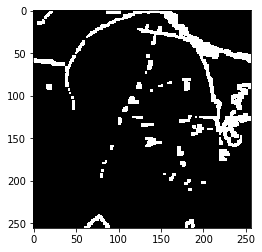

In [5]:
%%time

# Create HSV and grayscale formats
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define variables used in masking
max_gray = np.amax(gray)
min_color = np.array([0,0,max_gray-60])
max_color = np.array([255,60,max_gray])

# Create initial region mask
reg = cv2.inRange(hsv, min_color, max_color)

# plt.imshow(gray, cmap="gray")

# Blur the image for better line detection
blur = cv2.GaussianBlur(gray,(3, 3),0)

# Define morphologial transformation kernel
kernel = np.ones((3,3),np.uint8)

# Create edges and dilate to get better results
edges = cv2.Canny(gray, 100, 150)
edges = cv2.dilate(edges, kernel)

# plt.imshow(edges, cmap="gray")

# Intersect region and edges
mask = reg & edges
mask = cv2.dilate(mask, kernel)

# Save mask
cv2.imwrite(mask_filepath, mask)

plt.imshow(mask, cmap="gray")

<h1>Inpaint com Deep Generative Model with Contextual Attention</h1>

[2018-10-28 13:42:55 @gpus.py:39] Error reading GPU information, set no GPU.


Shape of image: (256, 256, 3)
Model loaded.


[2018-10-28 13:42:58 @PngImagePlugin.py:138] STREAM b'IHDR' 16 13
[2018-10-28 13:42:58 @PngImagePlugin.py:138] STREAM b'IDAT' 41 8192


./inpaints/inpaint_generative_img_0.png


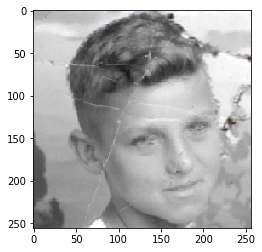

In [6]:
test.run_inpaint(image = img_filepath, 
                 mask = mask_filepath, 
                 output = inpaint_generative_filepath, 
                 checkpoint_dir = checkpoint_dir_path)

plt.imshow(np.asarray(Image.open(inpaint_generative_filepath)))
print(inpaint_generative_filepath)

<h1>Inpaint com OpenCV</h1>

./inpaints/inpaint_opencv_img_0.jpg
CPU times: user 108 ms, sys: 3.74 ms, total: 112 ms
Wall time: 111 ms


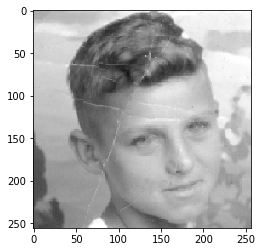

In [7]:
%%time

inpaint = cv2.inpaint(image,mask,3,cv2.INPAINT_TELEA)
save = cv2.cvtColor(inpaint, cv2.COLOR_BGR2RGB)

# Save inpaint 
cv2.imwrite(inpaint_opencv_filepath, save)

plt.imshow(inpaint)
print(inpaint_opencv_filepath)